# **Problem 1 - Learning Rate, Batch Size, FashionMNIST**

## Q1.

In [44]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import os 

In [43]:
class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta
		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []
		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]
		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)
		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)
		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss
		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return
		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth
		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=64, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()
		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)
		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)
		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))
		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
    
    # compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch
		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)
		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)
		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))
		# check to see if we are using a data iterator
		if useGen:
			self.model.fit(
				x=trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])
		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				x=trainData[0], y=trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)
		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]
    
		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")
		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)
		plt.show()

In [45]:
class config:
  # initialize the list of class label names
  CLASSES = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

  # define the minimum learning rate, maximum learning rate, batch size,
  # step size, CLR method, and number of epochs
  MIN_LR = 1e-9
  MAX_LR = 10
  BATCH_SIZE = 64
  STEP_SIZE = 1
  CLR_METHOD = "exp_range"
  NUM_EPOCHS = 5

In [46]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

In [59]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
# set arg to 1(not to find optimal learning rate)
args = vars(ap.parse_args(args=["--lr-find",'1']))

In [53]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...


In [31]:
from keras.metrics import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, AveragePooling2D, Dropout, Normalization
from tensorflow.keras.callbacks import *

In [32]:
# LeNet-5 Model
def LeNet():
  model = Sequential()
  model.add(Conv2D(6, 5, activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D(2))
  model.add(Conv2D(16, 5, activation='relu'))
  model.add(AveragePooling2D(2))
  model.add(Dense(120, activation='relu'))
  model.add(Flatten())
  model.add(Dense(84, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss = categorical_crossentropy, 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])      
  return model

In [54]:
import tensorflow as tf
# import keras
# from keras import layers

# %matplotlib inline

[INFO] finding learning rate...
Epoch 1/5
938/938 [==============================] - 55s 58ms/step - loss: 2.3031 - accuracy: 0.1010
Epoch 2/5
938/938 [==============================] - 57s 61ms/step - loss: 2.2932 - accuracy: 0.1144
Epoch 3/5
938/938 [==============================] - 54s 58ms/step - loss: 1.2225 - accuracy: 0.5780
Epoch 4/5
938/938 [==============================] - 55s 59ms/step - loss: 0.8128 - accuracy: 0.6957
Epoch 5/5
938/938 [==============================] - 58s 62ms/step - loss: 2.7401 - accuracy: 0.1713


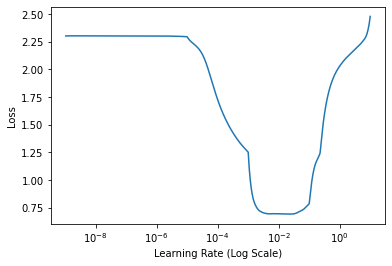

In [60]:
# initialize the model
clf = LeNet()

# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
if args["lr_find"] > 0:
  # initialize the learning rate finder and then train with learning
  # rates ranging from 1e-10 to 1e+1
  print("[INFO] finding learning rate...")
  lrf = LearningRateFinder(clf)
  lrf.find(aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE), 1e-9, 10, epochs=5,
           stepsPerEpoch=np.ceil((len(trainX) / float(config.BATCH_SIZE))), batchSize=config.BATCH_SIZE)
  # plot the loss for the various learning rates
  lrf.plot_loss()

$lr_{min} = 1e-5$

$lr_{max} =1e-2$

## Q2.

In [62]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [64]:
# Set CLR options
clr_step_size = len(trainX) // config.BATCH_SIZE
min_lr = 1e-5
max_lr = 1e-2
mode = config.CLR_METHOD
# Define the callback and train the network using batch size 64 and lrmin and lrmax values obtained in part 1
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
# Fit data to model
history = clf.fit(trainX, trainY,
            batch_size=config.BATCH_SIZE,
            epochs=config.NUM_EPOCHS,
            validation_data = (testX, testY),
            validation_steps = 100,
            callbacks=[clr])

Epoch 1/5
938/938 [==============================] - 48s 51ms/step - loss: 0.5151 - accuracy: 0.8083 - val_loss: 0.4144 - val_accuracy: 0.8500
Epoch 2/5
938/938 [==============================] - 43s 46ms/step - loss: 0.3275 - accuracy: 0.8778 - val_loss: 0.3093 - val_accuracy: 0.8864
Epoch 3/5
938/938 [==============================] - 46s 49ms/step - loss: 0.2954 - accuracy: 0.8892 - val_loss: 0.4682 - val_accuracy: 0.8314
Epoch 4/5
938/938 [==============================] - 43s 45ms/step - loss: 0.2893 - accuracy: 0.8921 - val_loss: 0.2970 - val_accuracy: 0.8903
Epoch 5/5
938/938 [==============================] - 43s 46ms/step - loss: 0.2606 - accuracy: 0.9024 - val_loss: 0.4050 - val_accuracy: 0.8470


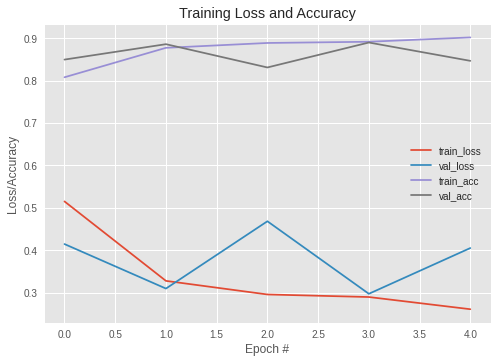

In [70]:
# Plot train/validation loss and accuracy curve
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

## Q3.

In [71]:
# LeNet-5 Model with a fixed learning rate
def LeNet_fixedlr():
  model = Sequential()
  model.add(Conv2D(6, 5, activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D(2))
  model.add(Conv2D(16, 5, activation='relu'))
  model.add(AveragePooling2D(2))
  model.add(Dense(120, activation='relu'))
  model.add(Flatten())
  model.add(Dense(84, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss = categorical_crossentropy, 
                optimizer = tf.keras.optimizers.Adam(lr = 1e-2), 
                metrics = ['accuracy'])      
  return model

In [76]:
strating_size = 32
batch_sizes = []
while strating_size < 4097:
  batch_sizes.append(strating_size)
  strating_size = strating_size * 2

clf_fixedlr = LeNet_fixedlr()
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for batch in batch_sizes:
  # continue training the same model
  history_fixedlr = clf_fixedlr.fit(trainX, trainY, batch_size = batch, epochs=1, validation_data = (testX, testY), validation_steps = 100)
  train_loss.append(history_fixedlr.history['loss'][-1])
  val_loss.append(history_fixedlr.history['val_loss'][-1])
  train_acc.append(history_fixedlr.history['accuracy'][-1])
  val_acc.append(history_fixedlr.history['val_accuracy'][-1])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


469/469 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8866

235/235 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9001

118/118 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9093

59/59 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9171

30/30 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9214

15/15 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9237

15/15 [==============================] - 34s 2s/step - loss: 0.1976 - accuracy: 0.9237 - val_loss: 0.2964 - val_accuracy: 0.8959


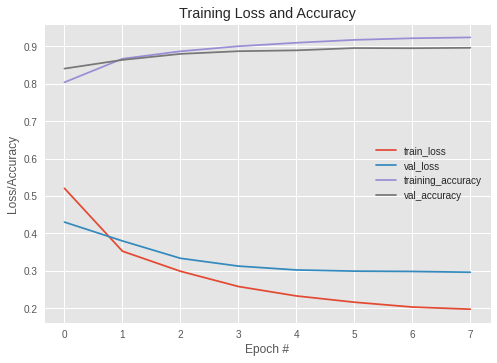

In [77]:
# Plot train/validation loss and accuracy curve
plt.style.use("ggplot")
plt.figure()
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.plot(train_acc, label = 'training_accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

They have similar range in loss and accuracy, but this final model has a better accuracy overall.

# **Problem 2 - Convolutional Neural Networks Architectures**

## Q1.

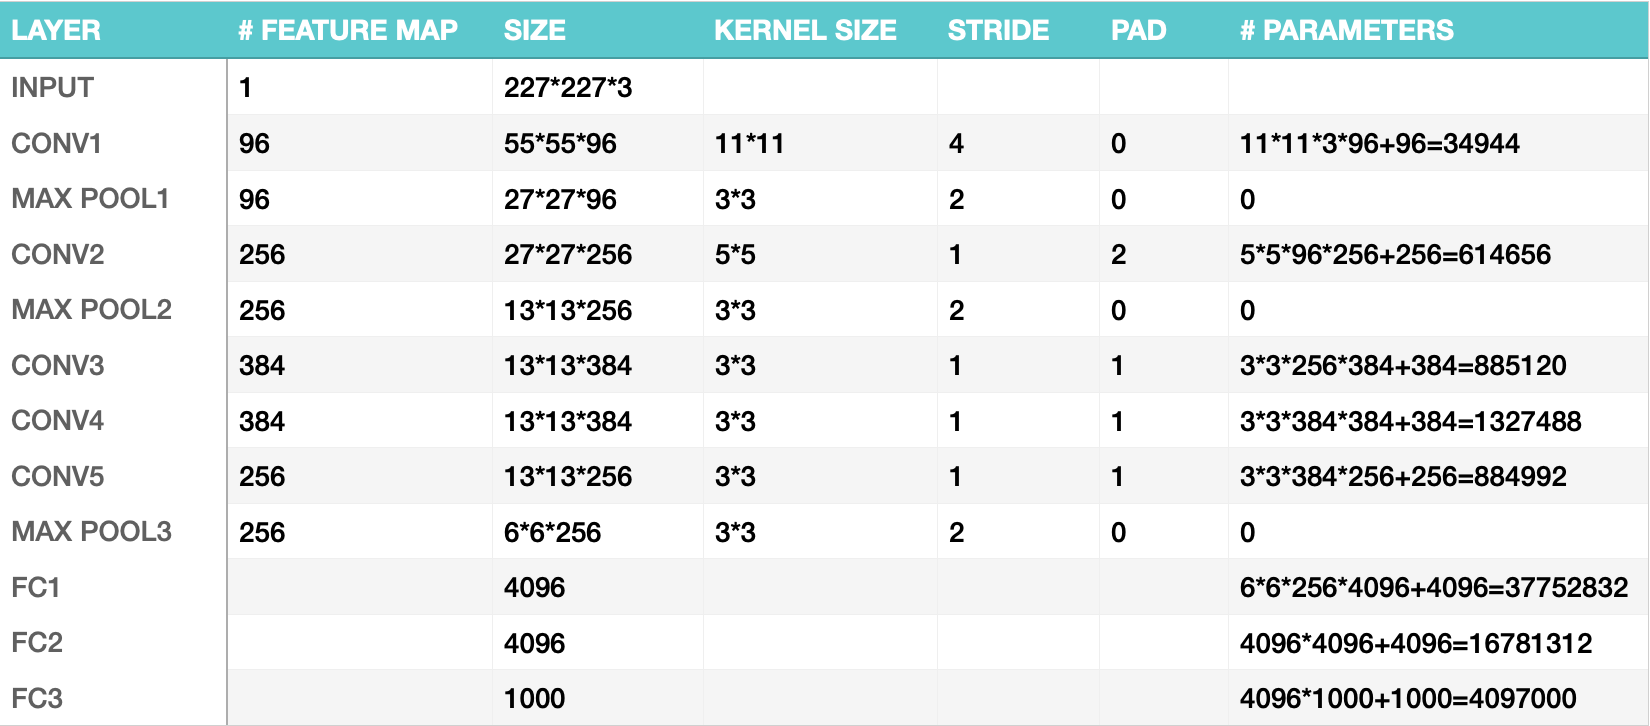

## Q2.

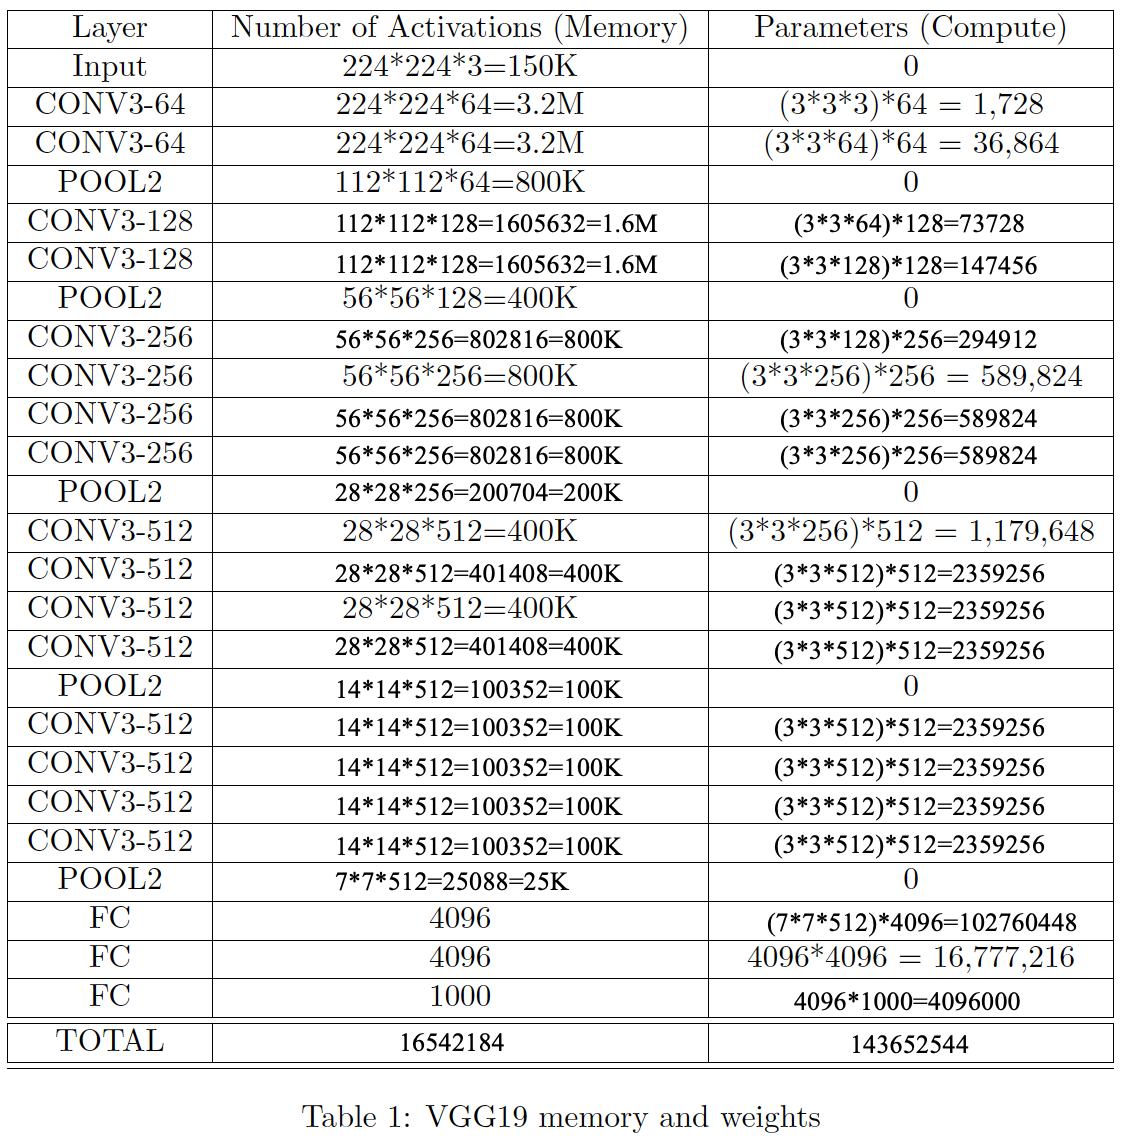

## Q4(a).

The Inception module helps running multiple operations (pooling, convolution) with multiple filter sizes (3x3, 5x5…) in parallel so that we do not have to face any trade-off.

## Q4(b).

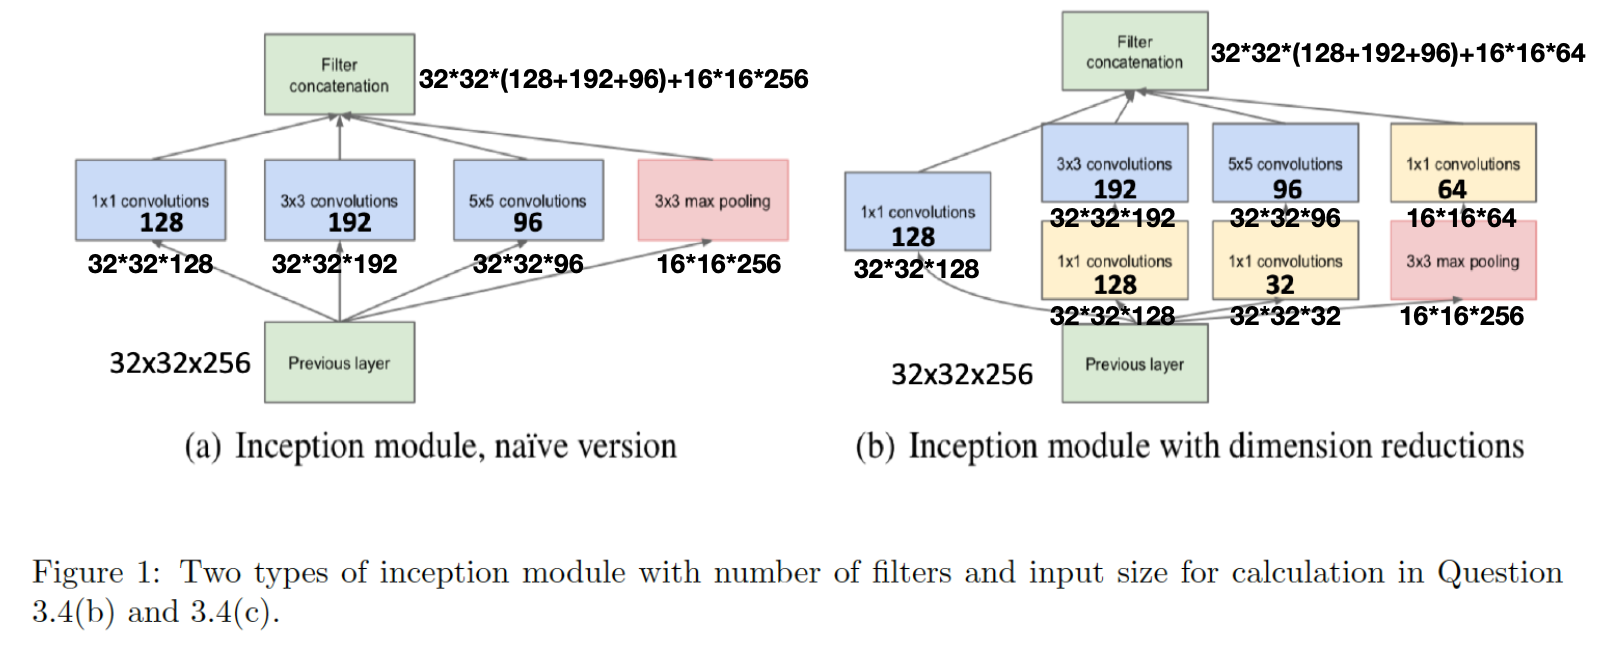

## Q4(c).

* Inception Module, naive version

32x32x128x1x1x256+32x32x192x3x3x256+32x32x96x5x5x256=1115684864

* Inception Module with dimension reductions

32x32x128x1x1x256+32x32x128x1x1x128+32x32x32x1x1x256+32x32x192x3x3x128+32x32x96x5x5x32+16x16x64x1x1x256=368050176

## Q4(d).

The computational complexity of the naive version inception module is 1115684864, which is about 3.03 times the computational complexity of the dimensional reduction version inception module, which is 368050176. The computational savings by the dimensional reduction version inception module is about 203.1%.

## Q5(a).

Faster-RCNN uses a region proposal method to create the sets of regions. Faster-RCNN possesses an extra CNN for gaining the regional proposal, which we call the regional proposal network, whereas Fast-RCNN uses selective search as its region proposal method.

## Q5(b).

A Region Proposal Network (RPN) takes an image (of any size) as input and outputs a set of rectangular object proposals, each with an objectness score. We model this process with a fully convolutional network.

To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer. This small network takes as input an n × n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature. This feature is fed into two sibling fullyconnected layers—a box-regression layer (reg) and a box-classification layer (cls). This architecture is naturally implemented with an n×n convolutional layer followed by two sibling 1 × 1 convolutional layers (for reg and cls, respectively).

## Q5(c).

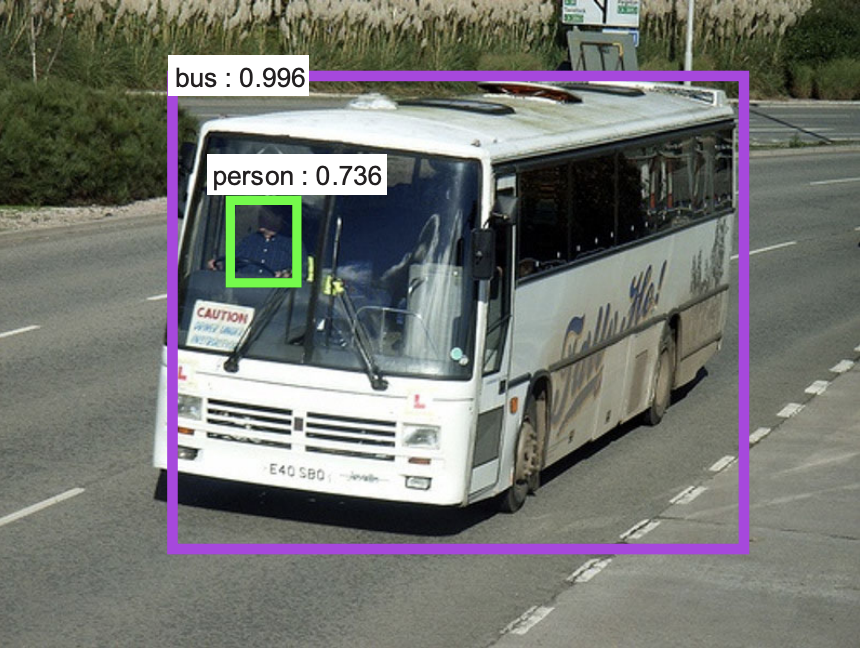

To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer. This small network takes as input an n × n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature. This feature is fed into two sibling fullyconnected layers—a box-regression layer (reg) and a box-classification layer (cls).In this case, it creates a green box and a purple box to show the prediction scores of person and bus respectively, which are 0.736 and 0.996.

## Q5(d).

Non-maximum suppression(NMS) is used in Faster-RCNN to reduce the number of proposals to roughly 2000. For the classification image of bus and person above, the person is overlap with the bus. For example, if we fix the IoU threshold at 0.8, it will only show the bus, because the prediction score for the bus is 0.996, which is higher than 0.8, but the prediction score for the person is 0.736, which is lower than 0.8.

# **Problem 3 - Transfer learning: Shallow learning vs Finetuning, Pytorch**

## Q1(a).

In [2]:
# check is gpu working
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# get the entire compressed folder
!wget http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz

--2022-11-06 02:23:13--  http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz [following]
--2022-11-06 02:23:13--  https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406351554 (388M) [application/x-gzip]
Saving to: ‘decathlon-1.0-data.tar.gz’

decathlon-1.0-data. 100%[===================>] 387.53M  35.3MB/s    in 12s     

2022-11-06 02:23:25 (33.5 MB/s) - ‘decathlon-1.0-data.tar.gz’ saved [406351554/406351554]



In [4]:
# extract the compressed folder
!tar -xzvf "/content/decathlon-1.0-data.tar.gz"

aircraft.tar
cifar100.tar
daimlerpedcls.tar
dtd.tar
gtsrb.tar
omniglot.tar
svhn.tar
ucf101.tar
vgg-flowers.tar


In [5]:
# extract the compressed folder for the dataset
! tar -xvf /content/gtsrb.tar

流式输出内容被截断，只能显示最后 5000 行内容。
gtsrb/train/0004/000914.jpg
gtsrb/train/0004/001388.jpg
gtsrb/train/0004/000867.jpg
gtsrb/train/0004/001164.jpg
gtsrb/train/0004/001104.jpg
gtsrb/train/0004/001197.jpg
gtsrb/train/0004/000493.jpg
gtsrb/train/0004/001231.jpg
gtsrb/train/0004/000612.jpg
gtsrb/train/0004/000422.jpg
gtsrb/train/0004/000298.jpg
gtsrb/train/0004/000891.jpg
gtsrb/train/0004/000827.jpg
gtsrb/train/0004/000981.jpg
gtsrb/train/0004/001032.jpg
gtsrb/train/0004/000384.jpg
gtsrb/train/0004/000730.jpg
gtsrb/train/0004/000089.jpg
gtsrb/train/0004/000627.jpg
gtsrb/train/0004/000926.jpg
gtsrb/train/0004/000173.jpg
gtsrb/train/0004/000255.jpg
gtsrb/train/0004/000986.jpg
gtsrb/train/0004/000347.jpg
gtsrb/train/0004/001048.jpg
gtsrb/train/0004/000752.jpg
gtsrb/train/0004/000224.jpg
gtsrb/train/0004/000488.jpg
gtsrb/train/0004/000814.jpg
gtsrb/train/0004/000702.jpg
gtsrb/train/0004/000547.jpg
gtsrb/train/0004/000535.jpg
gtsrb/train/0004/000559.jpg
gtsrb/train/0004/000428.jpg
gtsrb/train/0004/0003

In [6]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gtsrb'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


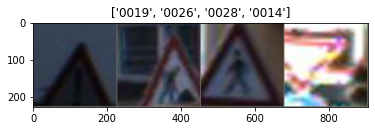

In [8]:
# visualize a few training images so as to understand the data augmentations
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

Text(0.5, 1.0, 'distribution of images per class in val dataset')

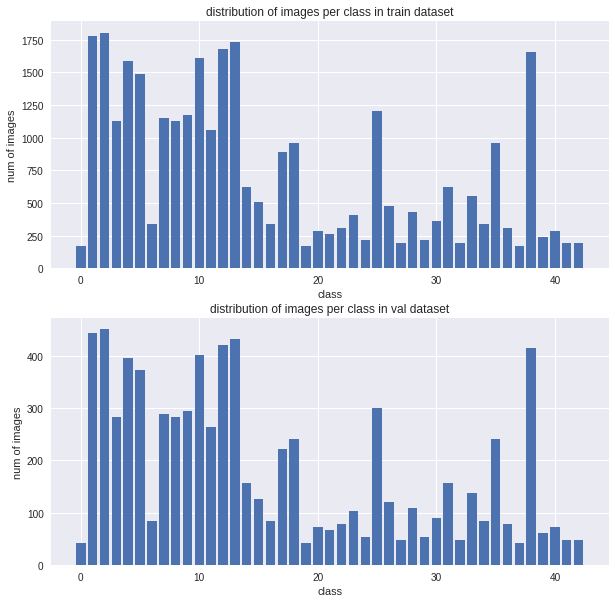

In [14]:
from collections import Counter

train_class = image_datasets['train'].classes
train_class_label = [label for pic, label in image_datasets['train']]
count_train_label = Counter(train_class_label)

val_class = image_datasets['val'].classes
val_class_label = [label for pic, label in image_datasets['val']]
count_val_label = Counter(val_class_label)

plt.style.use('seaborn')
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].bar(count_train_label.keys(), count_train_label.values())
axs[0].set_xlabel('class')
axs[0].set_ylabel('num of images')
axs[0].set_title('distribution of images per class in train dataset')

axs[1].bar(count_val_label.keys(),count_val_label.values())
axs[1].set_xlabel('class')
axs[1].set_ylabel('num of images')
axs[1].set_title('distribution of images per class in val dataset')

## Q1(b).

In [9]:
# Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Visualizing the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/11
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.5457 Acc: 0.5985
val Loss: 0.3089 Acc: 0.9181

Epoch 1/11
----------
train Loss: 0.4405 Acc: 0.8753
val Loss: 0.1026 Acc: 0.9727

Epoch 2/11
----------
train Loss: 0.3122 Acc: 0.9070
val Loss: 0.0674 Acc: 0.9770

Epoch 3/11
----------
train Loss: 0.2626 Acc: 0.9210
val Loss: 0.0531 Acc: 0.9857

Epoch 4/11
----------
train Loss: 0.2373 Acc: 0.9295
val Loss: 0.0505 Acc: 0.9871

Epoch 5/11
----------
train Loss: 0.2401 Acc: 0.9292
val Loss: 0.0476 Acc: 0.9872

Epoch 6/11
----------
train Loss: 0.2451 Acc: 0.9263
val Loss: 0.0454 Acc: 0.9874

Epoch 7/11
----------
train Loss: 0.2346 Acc: 0.9293
val Loss: 0.0461 Acc: 0.9878

Epoch 8/11
----------
train Loss: 0.2384 Acc: 0.9285
val Loss: 0.0438 Acc: 0.9871

Epoch 9/11
----------
train Loss: 0.2337 Acc: 0.9303
val Loss: 0.0469 Acc: 0.9871

Epoch 10/11
----------
train Loss: 0.2350 Acc: 0.9283
val Loss: 0.0461 Acc: 0.9883

Epoch 11/11
----------
train Loss: 0.2357 Acc: 0.9294
val Loss: 0.0450 Acc: 0.9888

Training complete in 66m

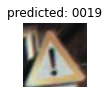

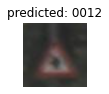

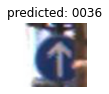

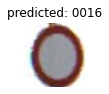

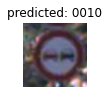

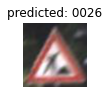

In [22]:
# Finetuning the convnet
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

# Train and evaluate
# reduce the number of epochs, but just make sure you decay the learning rate 3 times
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)
visualize_model(model_ft)

## Q1(c).

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/11
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6690 Acc: 0.8045
val Loss: 0.2612 Acc: 0.9143

Epoch 1/11
----------
train Loss: 0.2910 Acc: 0.9081
val Loss: 0.0624 Acc: 0.9745

Epoch 2/11
----------
train Loss: 0.2370 Acc: 0.9232
val Loss: 0.0783 Acc: 0.9703

Epoch 3/11
----------
train Loss: 0.2257 Acc: 0.9286
val Loss: 0.0460 Acc: 0.9856

Epoch 4/11
----------
train Loss: 0.1952 Acc: 0.9364
val Loss: 0.0196 Acc: 0.9939

Epoch 5/11
----------
train Loss: 0.1813 Acc: 0.9418
val Loss: 0.0172 Acc: 0.9949

Epoch 6/11
----------
train Loss: 0.1704 Acc: 0.9449
val Loss: 0.0316 Acc: 0.9895

Epoch 7/11
----------
train Loss: 0.1650 Acc: 0.9464
val Loss: 0.0158 Acc: 0.9954

Epoch 8/11
----------
train Loss: 0.1591 Acc: 0.9487
val Loss: 0.0151 Acc: 0.9959

Epoch 9/11
----------
train Loss: 0.1551 Acc: 0.9500
val Loss: 0.0118 Acc: 0.9968

Epoch 10/11
----------
train Loss: 0.1434 Acc: 0.9536
val Loss: 0.0163 Acc: 0.9959

Epoch 11/11
----------
train Loss: 0.1426 Acc: 0.9535
val Loss: 0.0061 Acc: 0.9978

Training complete in 66m

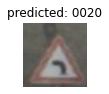

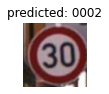

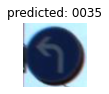

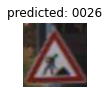

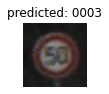

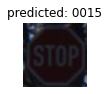

In [23]:
# keeping learning rate of all layers at 0.01

# Finetuning the convnet
model_fixedlr1 = models.resnet50(pretrained=True)
num_ftrs = model_fixedlr1.fc.in_features
# Here the size of each output sample is generalized to nn.Linear(num_ftrs, len(class_names)).
model_fixedlr1.fc = nn.Linear(num_ftrs, len(class_names))

model_fixedlr1 = model_fixedlr1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_fixedlr1.parameters(), lr=0.01, momentum=0.9)

# Constant LR 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=1)

# Train and evaluate
# reduce the number of epochs, but just make sure you decay the learning rate 3 times
model_fixedlr1 = train_model(model_fixedlr1, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)
visualize_model(model_fixedlr1)

Epoch 0/11
----------
train Loss: 3.3074 Acc: 0.1281
val Loss: 2.9758 Acc: 0.1495

Epoch 1/11
----------
train Loss: 2.7759 Acc: 0.2031
val Loss: 2.4119 Acc: 0.2821

Epoch 2/11
----------
train Loss: 2.2107 Acc: 0.3207
val Loss: 2.0204 Acc: 0.3771

Epoch 3/11
----------
train Loss: 1.6819 Acc: 0.4609
val Loss: 1.2516 Acc: 0.5782

Epoch 4/11
----------
train Loss: 1.0689 Acc: 0.6641
val Loss: 0.6353 Acc: 0.7766

Epoch 5/11
----------
train Loss: 0.6852 Acc: 0.7858
val Loss: 0.3068 Acc: 0.8973

Epoch 6/11
----------
train Loss: 0.5295 Acc: 0.8349
val Loss: 0.2369 Acc: 0.9248

Epoch 7/11
----------
train Loss: 0.4343 Acc: 0.8631
val Loss: 0.1511 Acc: 0.9485

Epoch 8/11
----------
train Loss: 0.3815 Acc: 0.8805
val Loss: 0.0943 Acc: 0.9691

Epoch 9/11
----------
train Loss: 0.3438 Acc: 0.8900
val Loss: 0.0730 Acc: 0.9776

Epoch 10/11
----------
train Loss: 0.3157 Acc: 0.9001
val Loss: 0.0907 Acc: 0.9733

Epoch 11/11
----------
train Loss: 0.3056 Acc: 0.9031
val Loss: 0.0545 Acc: 0.9821

Tr

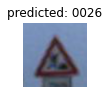

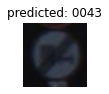

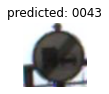

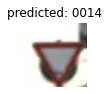

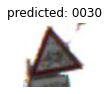

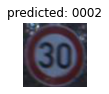

In [24]:
# keeping learning rate of all layers at 0.1

# Finetuning the convnet
model_fixedlr = models.resnet50(pretrained=True)
num_ftrs = model_fixedlr.fc.in_features
# Here the size of each output sample is generalized to nn.Linear(num_ftrs, len(class_names)).
model_fixedlr.fc = nn.Linear(num_ftrs, len(class_names))

model_fixedlr = model_fixedlr.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_fixedlr.parameters(), lr=0.1, momentum=0.9)

# Constant LR 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=1)

# Train and evaluate
# reduce the number of epochs, but just make sure you decay the learning rate 3 times
model_fixedlr = train_model(model_fixedlr, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=12)
visualize_model(model_fixedlr)

1. finetune with 0.001 exponential decay learning rate
* Best val Acc: 0.988778

2. finetune with 0.01 constant learning rate
* Best val Acc: 0.997832

3. finetune with 0.1 constant learning rate
* Best val Acc: 0.982147

Thus, 0.01 constant learning rate gives the best accuracy on the target dataset.

## Q2(a).

Epoch 0/9
----------
train Loss: 90.4331 Acc: 0.3776
val Loss: 68.8344 Acc: 0.4638

Epoch 1/9
----------
train Loss: 47.3495 Acc: 0.4600
val Loss: 54.2641 Acc: 0.4971

Epoch 2/9
----------
train Loss: 43.3212 Acc: 0.4935
val Loss: 31.8074 Acc: 0.5955

Epoch 3/9
----------
train Loss: 41.4446 Acc: 0.5108
val Loss: 35.0210 Acc: 0.5899

Epoch 4/9
----------
train Loss: 42.9836 Acc: 0.5153
val Loss: 34.9825 Acc: 0.6187

Epoch 5/9
----------
train Loss: 38.8874 Acc: 0.5350
val Loss: 24.0335 Acc: 0.6524

Epoch 6/9
----------
train Loss: 37.7525 Acc: 0.5393
val Loss: 37.5836 Acc: 0.5950

Epoch 7/9
----------
train Loss: 37.2203 Acc: 0.5469
val Loss: 48.2749 Acc: 0.5819

Epoch 8/9
----------
train Loss: 35.0830 Acc: 0.5624
val Loss: 21.1686 Acc: 0.6878

Epoch 9/9
----------
train Loss: 37.1811 Acc: 0.5534
val Loss: 26.9658 Acc: 0.6612

Training complete in 21m 35s
Best val Acc: 0.687835


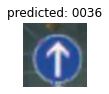

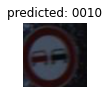

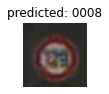

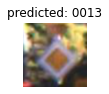

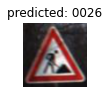

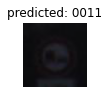

Epoch 0/9
----------
train Loss: 6.0322 Acc: 0.3974
val Loss: 2.3638 Acc: 0.5954

Epoch 1/9
----------
train Loss: 3.9670 Acc: 0.4804
val Loss: 4.5536 Acc: 0.5214

Epoch 2/9
----------
train Loss: 3.8569 Acc: 0.5070
val Loss: 3.1590 Acc: 0.6168

Epoch 3/9
----------
train Loss: 3.6777 Acc: 0.5252
val Loss: 2.9310 Acc: 0.6137

Epoch 4/9
----------
train Loss: 3.7027 Acc: 0.5390
val Loss: 1.6918 Acc: 0.6950

Epoch 5/9
----------
train Loss: 3.4862 Acc: 0.5460
val Loss: 2.2259 Acc: 0.6583

Epoch 6/9
----------
train Loss: 3.5571 Acc: 0.5504
val Loss: 3.3054 Acc: 0.6116

Epoch 7/9
----------
train Loss: 3.5547 Acc: 0.5604
val Loss: 1.5734 Acc: 0.7365

Epoch 8/9
----------
train Loss: 3.3064 Acc: 0.5715
val Loss: 2.8493 Acc: 0.6441

Epoch 9/9
----------
train Loss: 3.3607 Acc: 0.5716
val Loss: 2.7948 Acc: 0.6308

Training complete in 21m 37s
Best val Acc: 0.736547


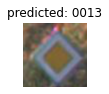

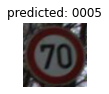

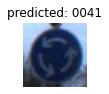

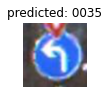

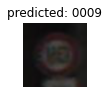

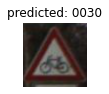

Epoch 0/9
----------
train Loss: 2.0108 Acc: 0.4367
val Loss: 1.2121 Acc: 0.6252

Epoch 1/9
----------
train Loss: 1.5338 Acc: 0.5427
val Loss: 1.0828 Acc: 0.6551

Epoch 2/9
----------
train Loss: 1.4104 Acc: 0.5792
val Loss: 0.9971 Acc: 0.6822

Epoch 3/9
----------
train Loss: 1.3605 Acc: 0.5902
val Loss: 0.9095 Acc: 0.7124

Epoch 4/9
----------
train Loss: 1.3147 Acc: 0.6039
val Loss: 0.8361 Acc: 0.7322

Epoch 5/9
----------
train Loss: 1.2903 Acc: 0.6105
val Loss: 0.8504 Acc: 0.7214

Epoch 6/9
----------
train Loss: 1.2610 Acc: 0.6208
val Loss: 0.7660 Acc: 0.7586

Epoch 7/9
----------
train Loss: 1.2365 Acc: 0.6228
val Loss: 0.7555 Acc: 0.7545

Epoch 8/9
----------
train Loss: 1.2267 Acc: 0.6281
val Loss: 0.8188 Acc: 0.7339

Epoch 9/9
----------
train Loss: 1.1888 Acc: 0.6383
val Loss: 0.6974 Acc: 0.7779

Training complete in 21m 36s
Best val Acc: 0.777863


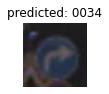

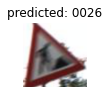

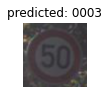

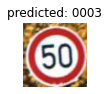

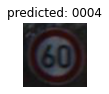

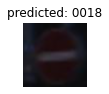

Epoch 0/9
----------
train Loss: 2.8202 Acc: 0.2995
val Loss: 2.1403 Acc: 0.4694

Epoch 1/9
----------
train Loss: 2.2025 Acc: 0.4292
val Loss: 1.7551 Acc: 0.5316

Epoch 2/9
----------
train Loss: 1.9645 Acc: 0.4774
val Loss: 1.5468 Acc: 0.5805

Epoch 3/9
----------
train Loss: 1.8285 Acc: 0.5024
val Loss: 1.4422 Acc: 0.6056

Epoch 4/9
----------
train Loss: 1.7350 Acc: 0.5232
val Loss: 1.3518 Acc: 0.6321

Epoch 5/9
----------
train Loss: 1.6675 Acc: 0.5359
val Loss: 1.2851 Acc: 0.6437

Epoch 6/9
----------
train Loss: 1.6218 Acc: 0.5446
val Loss: 1.2319 Acc: 0.6556

Epoch 7/9
----------
train Loss: 1.5668 Acc: 0.5600
val Loss: 1.2070 Acc: 0.6605

Epoch 8/9
----------
train Loss: 1.5326 Acc: 0.5660
val Loss: 1.1475 Acc: 0.6725

Epoch 9/9
----------
train Loss: 1.5061 Acc: 0.5715
val Loss: 1.1192 Acc: 0.6789

Training complete in 21m 36s
Best val Acc: 0.678908


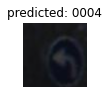

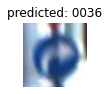

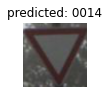

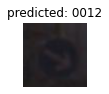

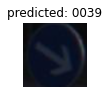

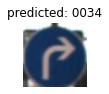

In [12]:
learning_rate = [1, 0.1, 0.01, 0.001]

for lr in learning_rate:
  model_conv = torchvision.models.resnet50(pretrained=True)
  # freeze all the network except the final layer
  for param in model_conv.parameters():
    param.requires_grad = False
    
  # Parameters of newly constructed modules have requires_grad=True by default
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, len(class_names))
  
  model_conv = model_conv.to(device)
  
  criterion = nn.CrossEntropyLoss()
  
  # Observe that only parameters of final layer are being optimized as
  # opposed to before.
  optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=lr, momentum=0.9)
  
  # Constant LR 
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=1)
  
  # Train and evaluate
  model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)
  visualize_model(model_conv)
  plt.ioff()
  plt.show()

## Q2(b).

1. finetune with 0.001 exponential decay learning rate
* Best val Acc: 0.988778

2. finetune with 0.01 constant learning rate
* Best val Acc: 0.997832

3. finetune with 0.1 constant learning rate
* Best val Acc: 0.982147

4. feature extraction with 1 constant learning rate
* Best val Acc: 0.687835

5. feature extraction with 0.1 constant learning rate
* Best val Acc: 0.736547

6. feature extraction with 0.01 constant learning rate
* Best val Acc: 0.777863

7. feature extraction with 0.001 constant learning rate
* Best val Acc: 0.678908

Thus, the approach using finetune with 0.01 constant learning rate is the winner. In the fine-tuning strategy all weights are changed when training on the new task (except for the weights of the last layers for the original task), whereas in the feature extraction strategy only the weights of the newly added last layers change during the training phase. Fine-tuning tunes the final parts of the network to better suit the problem at hand. And the learning rate 0.01 is a proper size for the model to learn faster, while not converge.

# **Problem 4 - Weakly and Semi-Supervised Learning for Image Classification**

## Q1.

1. Supervised learning aims to learn a function that, given a sample of data and desired outputs, approximates a function that maps inputs to outputs. 

* Mahajan's weakly supervision pretrain convolutional networks for hashtag prediction through finetuning the dataset on a large-scale pretrained model. In this case, the model could learn from the information provided by the pretaining. 

2. Semi-supervised learning aims to label unlabeled data points using knowledge learned from a small number of labeled data points.

* Yalinz's semi-spervised learning propose a pipeline, based on a teacher/student paradigm, that leverages a large collection of unlabelled images. In this case, the teacher model supervises the student model to learn the unlabeled target dataset. 

## Q2(a).

The model trained using hashtags is robust against noise in the labels.

Because an exact characterization of this label noise is difficult, Mahajan choose to investigate the effect of injecting additional label noise on the accuracy of our networks. He pretrain ResNeXt-101 32×16d networks on a version of IG-1B-17k where the hashtags is p% randomly replaced by hashtags obtained by sampling from the marginal distribution over hashtags (excluding the tag to be replaced). He only train the final linear classifier on the target task, because full finetuning may mask the damage caused by pretraining noise. 

The results suggest that the networks are remarkably resilient against label noise: a noise level of p = 10% leads to a loss of less than 1% in classification accuracy, and at p = 25% label noise, the reduction in accuracy is around 2%. These results suggest that label noise may be a limited issue if networks are trained on billions of images.

## Q2(b).

Prior studies in language modeling found that resampling Zipfian distributions reduces the impact of the head of the word distribution on the overall training loss, so Mahajan evaluates three sampling method: a natural sampling, square-root sampling and uniform sampling. 

The results show that resampling of the hashtag distribution is important in order to obtain good transfer to ImageNet image-classification tasks: using uniform or square-root sampling leads to an accuracy improvement of 5 to 6% irrespective of the number of ImageNet classes in the transfer task. In line with prior results, the figure also shows that larger hashtag vocabularies lead to increasing accuracy improvements as the number of target classes grows.

## Q3(a).

Semi-supervised learning leverages billions of unlabeled images along with a relatively smaller set of task-specific labeled data.

In Yalzin's research: (1) they train on the labeled data to get an initial teacher model; (2) for each class/label, they use the predictions of this teacher model to rank the unlabeled images and pick top-K images to construct a new training data; (3) they use this data to train a student model, which typically differs from the teacher model: hence we can target to reduce the complexity at test time; (4) finally, pre-trained student model is fine-tuned on the initial labeled data to circumvent potential labeling errors.

Training with two models, a teacher/student paradigm, produces a better model for a fixed complexity, even if the student and teacher have the same architecture.

Distillation was originally introduced to compress a large model, called the teacher, into a smaller one. The distillation procedure amounts to training the small model (the student) such that it reproduces at best the output of the teacher. The student model is typically smaller and faster than the teacher model. With the teacher-student modeling, teacher model makes prediction on unlabelled data, and the inferred labels are used to train the student in a supervised fashion, which is a type of distillation technique could be seen as a particular case of self-training.

## Q3(b).

K parameter is used to select top-K examples from unlabeled data for each target label to collect a large number of images while limiting the labelling noise.

P parameter is the number of concepts selected in an image, accounting for the expectation of only a few number of relevant classes to occur in each image. 

The reason for choosing P > 1 is that it is difficult to identify accurately under-represented concepts, or some may be occulted by more prominent co-occurring concepts, since P=1 may exclude the true label of the image with multiple relevant concepts.

## Q3(c).

The teacher model is run on each example in U to obtain the softmax prediction vector and retain only the classes associated with the P highest scores for each image. Then, for each class we rank the images based on the corresponding classification scores. The top–K images are chosen to create a new labeled dataset. 

An image in this new dataset can belong to more than one class, because P>1 allows replicated images in the top K images.

## Q3(d).

The performance first improves as we increase the value of K due to increase in diversity as well as hardness of examples. But increasing K further introduces a lot of labeling noise in dataset and the accuracy drops.

# **Convert To PDF**

In [15]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain

In [16]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,040 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.la

In [17]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended --fix-missing

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-fonts-recommended set to manually installed.
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  texlive-generic-recommended
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 15.9 kB of archives.
After this operation, 69.6 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 texlive-generic-recommended all 2017.20180305-1 [15.9 kB]
Fetched 15.9 kB in 0s (248 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Front

The pdf will appear in the files tab on the left.

In [18]:
!jupyter nbconvert --to pdf /content/Assignment_3.ipynb

[NbConvertApp] WARNING | pattern '/content/Assignment_3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--e